In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import files
import zipfile
import os

In [ ]:
#트레이닝 데이터 준비

import zipfile
import os

print(" 'data.zip' 파일을 업로드하세요.")
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

extract_path = "/content"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f" '{zip_filename}' 압축 해제 완료")
print("/content/data 안의 클래스 폴더:")
!ls /content/data

 'data.zip' 파일을 업로드하세요.


Saving data.zip to data.zip
 'data.zip' 압축 해제 완료
/content/data 안의 클래스 폴더:
call_duck  goose  mallard  other  pekin


In [ ]:
#데이터 증강

from torchvision import transforms
from PIL import Image
import os
import random
from tqdm import tqdm

augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.95, 1.05)),
])

data_root = "/content/data"

image_extensions = ['.jpg', '.jpeg', '.png']

for class_name in os.listdir(data_root):
    class_path = os.path.join(data_root, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"클래스 '{class_name}' 증강 중...")

    img_files = [f for f in os.listdir(class_path) if os.path.splitext(f)[-1].lower() in image_extensions]

    for img_name in tqdm(img_files):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
            augmented = augment(img)

            name, ext = os.path.splitext(img_name)
            new_name = f"{name}_aug1{ext}"
            save_path = os.path.join(class_path, new_name)
            augmented.save(save_path)
        except Exception as e:
            print(f"이미지 오류: {img_name}, {e}")

클래스 'other' 증강 중...


100%|██████████| 10/10 [00:00<00:00, 54.91it/s]


클래스 'mallard' 증강 중...


100%|██████████| 10/10 [00:00<00:00, 72.92it/s]


클래스 'pekin' 증강 중...


100%|██████████| 10/10 [00:00<00:00, 68.27it/s]


클래스 'goose' 증강 중...


100%|██████████| 10/10 [00:00<00:00, 68.00it/s]


클래스 'call_duck' 증강 중...


100%|██████████| 10/10 [00:00<00:00, 13.27it/s]


In [ ]:
#모델 트레이닝

import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import os

def train_call_duck_classifier_full(data_dir="/content/data", num_epochs=15, batch_size=8):
    # 전처리 정의
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    class CleanImageFolder(datasets.ImageFolder):
        def find_classes(self, directory):
            classes = [d.name for d in os.scandir(directory) if d.is_dir() and d.name != '.ipynb_checkpoints']
            classes.sort()
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx

    dataset = CleanImageFolder(data_dir, transform=transform)
    class_names = dataset.classes
    num_classes = len(class_names)

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = models.mobilenet_v3_large(pretrained=True)
    model.classifier[3] = nn.Linear(1280, num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}")

    # 모델 저장
    torch.save(model.state_dict(), "/content/mobilenetv3_call_duck.pt")
    print("훈련 완료 및 모델 저장됨")

    return model, class_names

In [ ]:
#모델 트레이닝 실행
model, class_names = train_call_duck_classifier_full()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 42.3MB/s]


[Epoch 1] Loss: 19.0014
[Epoch 2] Loss: 11.8330
[Epoch 3] Loss: 7.7908
[Epoch 4] Loss: 5.1101
[Epoch 5] Loss: 3.5924
[Epoch 6] Loss: 2.0763
[Epoch 7] Loss: 1.3515
[Epoch 8] Loss: 0.9889
[Epoch 9] Loss: 0.9645
[Epoch 10] Loss: 0.6780
[Epoch 11] Loss: 0.7116
[Epoch 12] Loss: 0.3181
[Epoch 13] Loss: 0.2198
[Epoch 14] Loss: 0.4322
[Epoch 15] Loss: 0.1730
훈련 완료 및 모델 저장됨


Saving OIP-1085859279.jpg to OIP-1085859279.jpg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


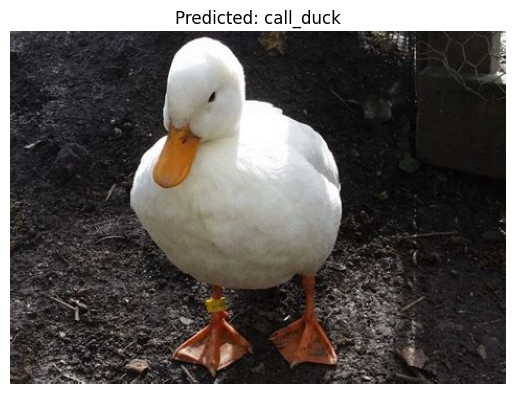

이 이미지는 'call_duck'로 분류되었습니다.


In [ ]:
#이미지 분류

from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = nn.Linear(1280, 5)
model.load_state_dict(torch.load("/content/mobilenetv3_call_duck.pt", map_location='cpu'))
model.eval()

class_names = ['call_duck', 'goose', 'mallard', 'other', 'pekin']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).item()

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[pred]}")
plt.show()
print(f"이 이미지는 '{class_names[pred]}'로 분류되었습니다.")

In [ ]:
#가중치 로드

import torch.nn as nn
from torchvision import models

model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = nn.Linear(1280, 5)  # 콜덕 / 기타

model.load_state_dict(torch.load("/content/mobilenetv3_call_duck.pt", map_location='cpu'))
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


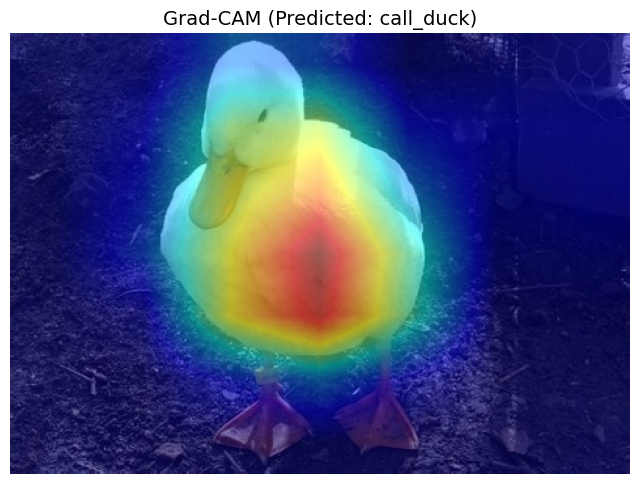

Result: call_duck


In [ ]:
#Grad-CAM 시각화

import numpy as np
import cv2

def show_gradcam(image_path, model, class_names, target_layer='features.16'):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    features, gradients = [], []

    def forward_hook(module, input, output):
        features.append(output)
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    layer = dict([*model.named_modules()])[target_layer]
    fh = layer.register_forward_hook(forward_hook)
    bh = layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    pred_name = class_names[pred_class]

    model.zero_grad()
    output[0, pred_class].backward()

    pooled_grad = torch.mean(gradients[0], dim=(0, 2, 3))
    fmap = features[0][0]
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32).to(device)
    for i in range(len(pooled_grad)):
        cam += pooled_grad[i] * fmap[i, :, :]

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max() if cam.max() != 0 else cam

    cam_resized = cv2.resize(cam, image.size)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (np.array(image) * 0.5 + heatmap * 0.5).astype(np.uint8)

    plt.figure(figsize=(8, 6))
    plt.imshow(overlay)
    plt.title(f"Grad-CAM (Predicted: {pred_name})", fontsize=14)
    plt.axis('off')
    plt.show()

    fh.remove()
    bh.remove()
    print(f"Result: {pred_name}")

show_gradcam(image_path, model, class_names)

In [ ]:
# 평가용 데이터 준비

from google.colab import files
import zipfile
import os

print("'eval_data.zip' 파일을 업로드하세요.")
uploaded = files.upload()

zip_filename = list(uploaded.keys())[0]

extract_path = "/content"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"'{zip_filename}' 압축 해제 완료")

eval_path = os.path.join(extract_path, "eval_data")
print("\n /content/eval_data 안의 클래스 폴더:")
!ls /content/eval_data

'eval_data.zip' 파일을 업로드하세요.


Saving eval_data(1).zip to eval_data(1).zip
'eval_data(1).zip' 압축 해제 완료

 /content/eval_data 안의 클래스 폴더:
call_duck  goose  mallard  other  pekin


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


정확도: 82.0 %

              precision    recall  f1-score   support

   call_duck       0.82      0.90      0.86        10
       goose       0.83      0.50      0.62        10
     mallard       1.00      1.00      1.00        10
       other       0.90      0.90      0.90        10
       pekin       0.62      0.80      0.70        10

    accuracy                           0.82        50
   macro avg       0.83      0.82      0.82        50
weighted avg       0.83      0.82      0.82        50



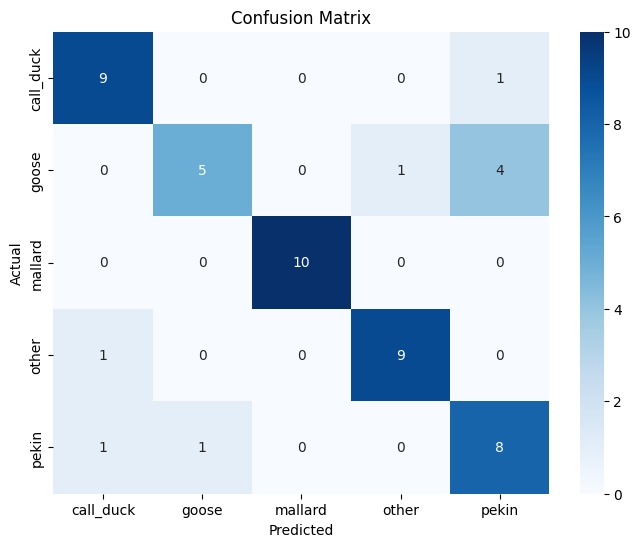

In [ ]:
#정확도 평가

import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

# 데이터 경로: 평가용 폴더 (클래스별로 하위 폴더 구분)
eval_dir = "/content/eval_data"  # 예: eval_data/call_duck/, eval_data/goose/ ...

class_names = sorted([d for d in os.listdir(eval_dir) if os.path.isdir(os.path.join(eval_dir, d))])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

eval_dataset = datasets.ImageFolder(eval_dir, transform=transform)
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = nn.Linear(1280, len(class_names))
model.load_state_dict(torch.load("/content/mobilenetv3_call_duck.pt", map_location='cpu'))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in eval_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())

print("정확도:", np.mean(np.array(y_true) == np.array(y_pred)) * 100, "%\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import torch
from torchvision import models
from torch.utils.mobile_optimizer import optimize_for_mobile

model = models.mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(1280, 5)
model.load_state_dict(torch.load("mobilenetv3_call_duck.pt"))
model.eval()

scripted = torch.jit.script(model)

optimized = optimize_for_mobile(scripted)

optimized._save_for_lite_interpreter("call_duck_classifier.ptl")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 127MB/s] 
